     plot burn   site        date  decid_prop_canopy  piba_prop_canopy  \
0  C1-14A   C1  C1-14  2018-06-13           0.032258          0.709677   
1  C1-17A   C1  C1-17  2018-06-10           0.000000          0.000000   
2  C1-19A   C1  C1-19  2018-06-13           0.000000          0.000000   
3  C1-19B   C1  C1-19  2018-06-13           0.000000          0.650000   
4  C1-21A   C1  C1-21  2018-06-14           0.023529          0.000000   

  stand_dominance  time_after_fire moisture nonvascular_functionalgroup  \
0       Jack Pine               83    Xeric                      Lichen   
1    Black Spruce               65    Mesic                      Lichen   
2    Black Spruce               82   Hydric                    Sphagnum   
3       Jack Pine               84    Xeric                      Lichen   
4    Black Spruce               79   Hydric                  Colonizers   

   avg_org_carbon ecozone  avg_carbon_stock   latitude  longitude   
0            4.05  shield          

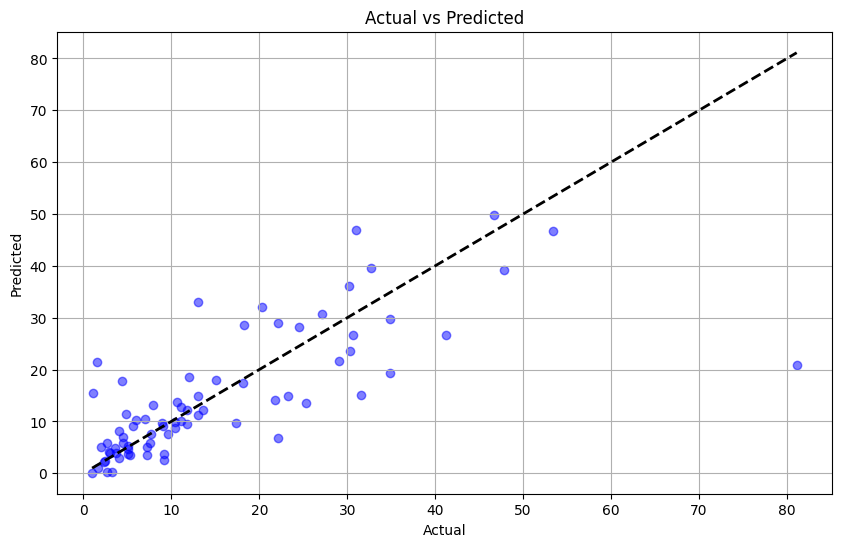

In [1]:
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# Load the dataset
data = pd.read_csv("SoilOrganicCarbonRecovery_NorthwestTerritories.csv")

# Data preprocessing
print(data.head())
print("Null values found in columns:")
data.isnull().sum()

# Drop rows with missing data
data.dropna(inplace=True)
data.isnull().sum()

# Encoding categorical variables
label_encoders = {}
categorical_columns = ['plot', 'burn', 'site']
for col in categorical_columns:
    label_encoders[col] = LabelEncoder()
    data[col] = label_encoders[col].fit_transform(data[col])

data = pd.get_dummies(data, columns=['stand_dominance', 'ecozone', 'moisture', 'nonvascular_functionalgroup'])

# Splitting data into features and target variable
X = data.drop(columns=['plot', 'date', 'avg_org_carbon', 'avg_carbon_stock'])
y = data['avg_org_carbon']

# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model selection and hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5]
}

gb = GradientBoostingRegressor(random_state=42)
grid_search = GridSearchCV(gb, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Best hyperparameters
best_params = grid_search.best_params_

# Training the model with best hyperparameters
best_gb = GradientBoostingRegressor(**best_params, random_state=42)
best_gb.fit(X_train, y_train)

# Model evaluation
y_pred = best_gb.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# Plotting actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.grid(True)
plt.show()
